## Carga y exploración inicial

In [ ]:
import pandas as pd

file_path = 'data/Datos_proyecto.xlsx'

try:
    df = pd.read_excel(file_path)
    print("¡Archivo cargado exitosamente!")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{file_path}'.")
    df = pd.DataFrame()


if not df.empty:
    
    # Vistazo a las primeras 5 filas
    print("\n--- Primeras 5 filas de los datos: ---")
    display(df.head())
    
    # Obtener un resumen del DataFrame.
    print("\n--- Información general del DataFrame: ---")
    df.info()
    
    # Contar cuántas filas hay para cada categoría (label).
    print("\n--- Distribución de las clases (labels): ---")
    print(df['labels'].value_counts())

¡Archivo cargado exitosamente!

--- Primeras 5 filas de los datos: ---


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3



--- Información general del DataFrame: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB

--- Distribución de las clases (labels): ---
labels
4    1025
3     894
1     505
Name: count, dtype: int64


No hay filas nulas, pero hay más labels de las categorías 4 y 3 que de 1, por lo que el modelo podría tender a predecir 4 o 3 simplemente porque aparece más veces.

C:\Users\carlo\AppData\Local\Temp\ipykernel_12896\1462879198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=df, palette='viridis')


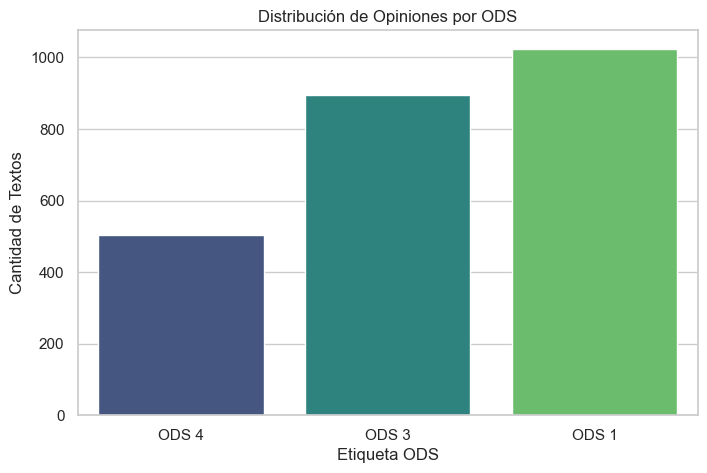

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(x='labels', data=df, palette='viridis')
plt.title('Distribución de Opiniones por ODS')
plt.xlabel('Etiqueta ODS')
plt.ylabel('Cantidad de Textos')
plt.xticks(ticks=[0, 1, 2], labels=['ODS 4', 'ODS 3', 'ODS 1'])
plt.show()

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install spacy==3.7.0
!pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl


In [5]:
import re
import spacy
from nltk.corpus import stopwords

# Cargar el modelo de español de spacy. Spacy se va a encargar de la lematización.
nlp = spacy.load("es_core_news_sm")
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar puntuación y números
    texto = re.sub(r'[^a-záéíóúñü]', ' ', texto)
    
    # Lematización y eliminación de stop words
    doc = nlp(texto)
    tokens_limpios = [token.lemma_ for token in doc if token.text not in stop_words and len(token.text) > 2]
    
    return " ".join(tokens_limpios)

df['texto_limpio'] = df['textos'].apply(limpiar_texto)

print("--- Comparación del texto original y el texto limpio ---")
display(df[['textos', 'texto_limpio']].head())

--- Comparación del texto original y el texto limpio ---


,textos,texto_limpio
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",aprendizaje educación considerar sinónir escol...
1,Para los niños más pequeños (bebés y niños peq...,niño pequeño bebé niño pequeño capacitación es...
2,"Además, la formación de especialistas en medic...",además formación especialista medicina general...
3,En los países de la OCDE se tiende a pasar de ...,país ocde tender pasar curso obligatorio optat...
4,Este grupo se centró en las personas que padec...,grupo centrar persona padecer trastorno mental...


Se limita el vocabulario a las 3000 palabras más frecuentes y se convierte el texto a vectores usando Tf-Idf

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_ngram = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X = vectorizer_ngram.fit_transform(df['texto_limpio'])
y = df['labels']

print("Forma de la nueva matriz de características (X):", X.shape)

Forma de la nueva matriz de características (X): (2424, 5000)


Separar conjunto de entrenamiento y de prueba.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,   
    random_state=42,  
    stratify=y        
)

print("Distribución de clases en el conjunto de entrenamiento (antes de SMOTE):")
print(y_train.value_counts())

Distribución de clases en el conjunto de entrenamiento (antes de SMOTE):
labels
4    820
3    715
1    404
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Aplicar SMOTE solo a los datos de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Forma de X_train antes de SMOTE:", X_train.shape)
print("Forma de X_train después de SMOTE:", X_train_smote.shape)

print(pd.Series(y_train_smote).value_counts())

Forma de X_train antes de SMOTE: (1939, 5000)
Forma de X_train después de SMOTE: (2460, 5000)
labels
3    820
1    820
4    820
Name: count, dtype: int64


Entrenar los 3 modelos. Se eligió:
- Regresión Logística
- Bayes Multinomial
- Support Vector Machine (SVC)

In [ ]:
from sklearn.calibration import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# =============================================================================
# 1. BÚSQUEDA PARA REGRESIÓN LOGÍSTICA
# =============================================================================

pipeline_lr = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

# 'classifier__C' se refiere al parámetro 'C' del paso 'classifier'
parameters_lr = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"Mejor F1-score para LR: {grid_search_lr.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_lr.best_params_}\n")


# =============================================================================
# 2. BÚSQUEDA PARA NAIVE BAYES MULTINOMIAL
# =============================================================================
print("--- Iniciando GridSearchCV para Naive Bayes ---")

pipeline_nb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', MultinomialNB())
])

# Naive Bayes tiene un parámetro principal: 'alpha' (suavizado)
parameters_nb = {
    'classifier__alpha': [0.1, 0.5, 1.0]
}

grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train, y_train)

print(f"Mejor F1-score para NB: {grid_search_nb.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_nb.best_params_}\n")


# =============================================================================
# 3. BÚSQUEDA PARA SUPPORT VECTOR MACHINE (LINEAR SVC)
# =============================================================================
print("--- Iniciando GridSearchCV para SVM (LinearSVC) ---")

pipeline_svc = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42, max_iter=5000))
])

# El parámetro clave de LinearSVC es 'C' (penalización del error)
parameters_svc = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_svc = GridSearchCV(pipeline_svc, parameters_svc, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)

print(f"Mejor F1-score para SVM: {grid_search_svc.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_svc.best_params_}\n")


# Encontrar el mejor
scores = {
    'Logistic Regression': grid_search_lr.best_score_,
    'Naive Bayes': grid_search_nb.best_score_,
    'SVM (LinearSVC)': grid_search_svc.best_score_
}

# Encontrar el modelo con el mejor score
best_model_name = max(scores, key=scores.get)
print(f"El mejor modelo es: {best_model_name} con un F1-score de {scores[best_model_name]:.4f}")

# Guardar el mejor modelo para usarlo después
if best_model_name == 'Logistic Regression':
    best_model = grid_search_lr.best_estimator_
elif best_model_name == 'Naive Bayes':
    best_model = grid_search_nb.best_estimator_
else:
    best_model = grid_search_svc.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor F1-score para LR: 0.9747
Mejores parámetros: {'classifier__C': 1}

--- Iniciando GridSearchCV para Naive Bayes ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor F1-score para NB: 0.9682
Mejores parámetros: {'classifier__alpha': 0.5}

--- Iniciando GridSearchCV para SVM (LinearSVC) ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor F1-score para SVM: 0.9752
Mejores parámetros: {'classifier__C': 0.1}

El mejor modelo es: SVM (LinearSVC) con un F1-score de 0.9752


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


  Resultados Finales: Regresión Logística
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.96      0.94      0.95       101
    ODS 3 (Salud)       0.97      0.98      0.97       179
ODS 4 (Educación)       0.98      0.98      0.98       205

         accuracy                           0.97       485
        macro avg       0.97      0.97      0.97       485
     weighted avg       0.97      0.97      0.97       485



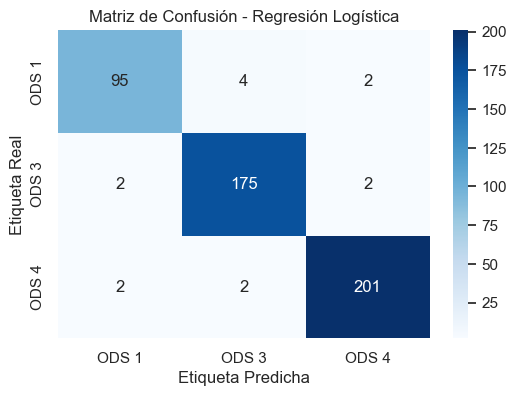


    Resultados Finales: Naive Bayes
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.90      0.97      0.93       101
    ODS 3 (Salud)       0.96      0.95      0.96       179
ODS 4 (Educación)       0.98      0.95      0.97       205

         accuracy                           0.95       485
        macro avg       0.95      0.96      0.95       485
     weighted avg       0.96      0.95      0.95       485



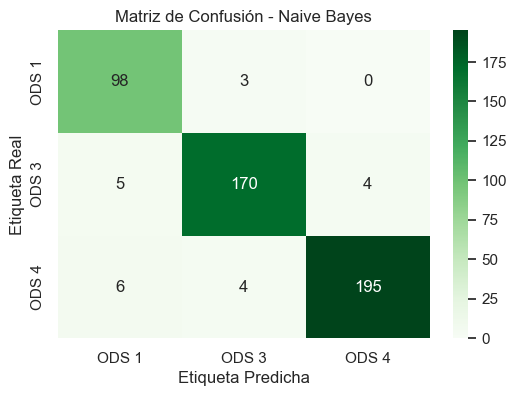


     Resultados Finales: SVM (LinearSVC)
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.96      0.95      0.96       101
    ODS 3 (Salud)       0.97      0.97      0.97       179
ODS 4 (Educación)       0.98      0.98      0.98       205

         accuracy                           0.97       485
        macro avg       0.97      0.97      0.97       485
     weighted avg       0.97      0.97      0.97       485



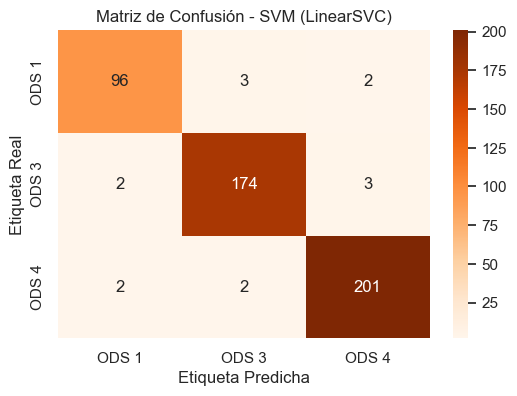

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_lr_model = grid_search_lr.best_estimator_
best_nb_model = grid_search_nb.best_estimator_
best_svc_model = grid_search_svc.best_estimator_


# --- 1. Evaluación de Regresión Logística ---
print("="*40)
print("  Resultados Finales: Regresión Logística")
print("="*40)
y_pred_lr = best_lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- 2. Evaluación de Naive Bayes ---
print("\n" + "="*40)
print("    Resultados Finales: Naive Bayes")
print("="*40)
y_pred_nb = best_nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - Naive Bayes')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- 3. Evaluación de SVM (LinearSVC) ---
print("\n" + "="*40)
print("     Resultados Finales: SVM (LinearSVC)")
print("="*40)
y_pred_svc = best_svc_model.predict(X_test)
print(classification_report(y_test, y_pred_svc, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - SVM (LinearSVC)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

In [ ]:
final_predictions = best_model.predict(X_test)

df_resultados = pd.DataFrame({
    'textos': df.loc[y_test.index, 'textos'],
    'labels_reales': y_test,
    'labels_predichas': final_predictions
})

output_filename = 'data/predicciones_grupo_16.xlsx'
df_resultados.to_excel(output_filename, index=False)

display(df_resultados.head())

,textos,labels_reales,labels_predichas
102,La relación entre el estatus étnico y el consu...,3,3
1220,"En los países de la OCDE, por cada reducción d...",3,3
233,Una segunda etapa de seguimiento ocurre a los ...,4,4
2056,La persona respetable más pobre de cualquier s...,1,1
698,En ellos se basan las publicaciones anuales co...,4,4


In [ ]:
def mostrar_palabras_clave(model_pipeline, vectorizer, top_n=20):
    classifier = model_pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()
    
    # Coeficientes por palabra
    coefs_por_clase = classifier.coef_
    
    # Palabras más importantes para cada clase
    for i, class_label in enumerate(classifier.classes_):
        coefs = coefs_por_clase[i]
        top_coef_indices = coefs.argsort()[-top_n:]
        
        top_words = [feature_names[j] for j in top_coef_indices]
        
        print(f"--- ODS {class_label} ---")
        print(", ".join(reversed(top_words)))
        print("")


print("Palabras más influyentes por ODS:")
mostrar_palabras_clave(best_model, vectorizer_ngram)

Palabras clave más influyentes por ODS:
--- ODS 1 ---
pobreza, pobre, hogar, ingreso, social, privación, protección social, protección, transferencia, niño, empleo, crecimiento, familia, vivir, umbral, urbano, vivienda, trabajo, multidimensional, pobreza infantil

--- ODS 3 ---
salud, atención, médico, paciente, enfermedad, sanitario, alcohol, mortalidad, tratamiento, mental, hospital, droga, servicio, medicamento, consumo, atención primario, muerte, cáncer, vih, hospitalario

--- ODS 4 ---
educación, escuela, estudiante, educativo, docente, aprendizaje, escolar, alumno, profesor, habilidad, enseñanza, maestro, evaluación, formación, universidad, superior, pisa, sistema educativo, ciencia, personal

